# Isochrones with GraphHopper and pydeck

By [Andrew Duberstein](https://duberste.in)

## What's an isochrone? 

Essentially an isochrone is geometry on a map that answers the question

> How far can I get from X point in Y minutes?

For example, in the image below, the outer blue ring is reachable in ten minutes, and the inner green one is reachable in five, from the centroid.

Most major routing engines can calculate isochrones. This in particular is from [the GraphHopper docs](https://graphhopper.com/api/1/examples/#isochrone), 

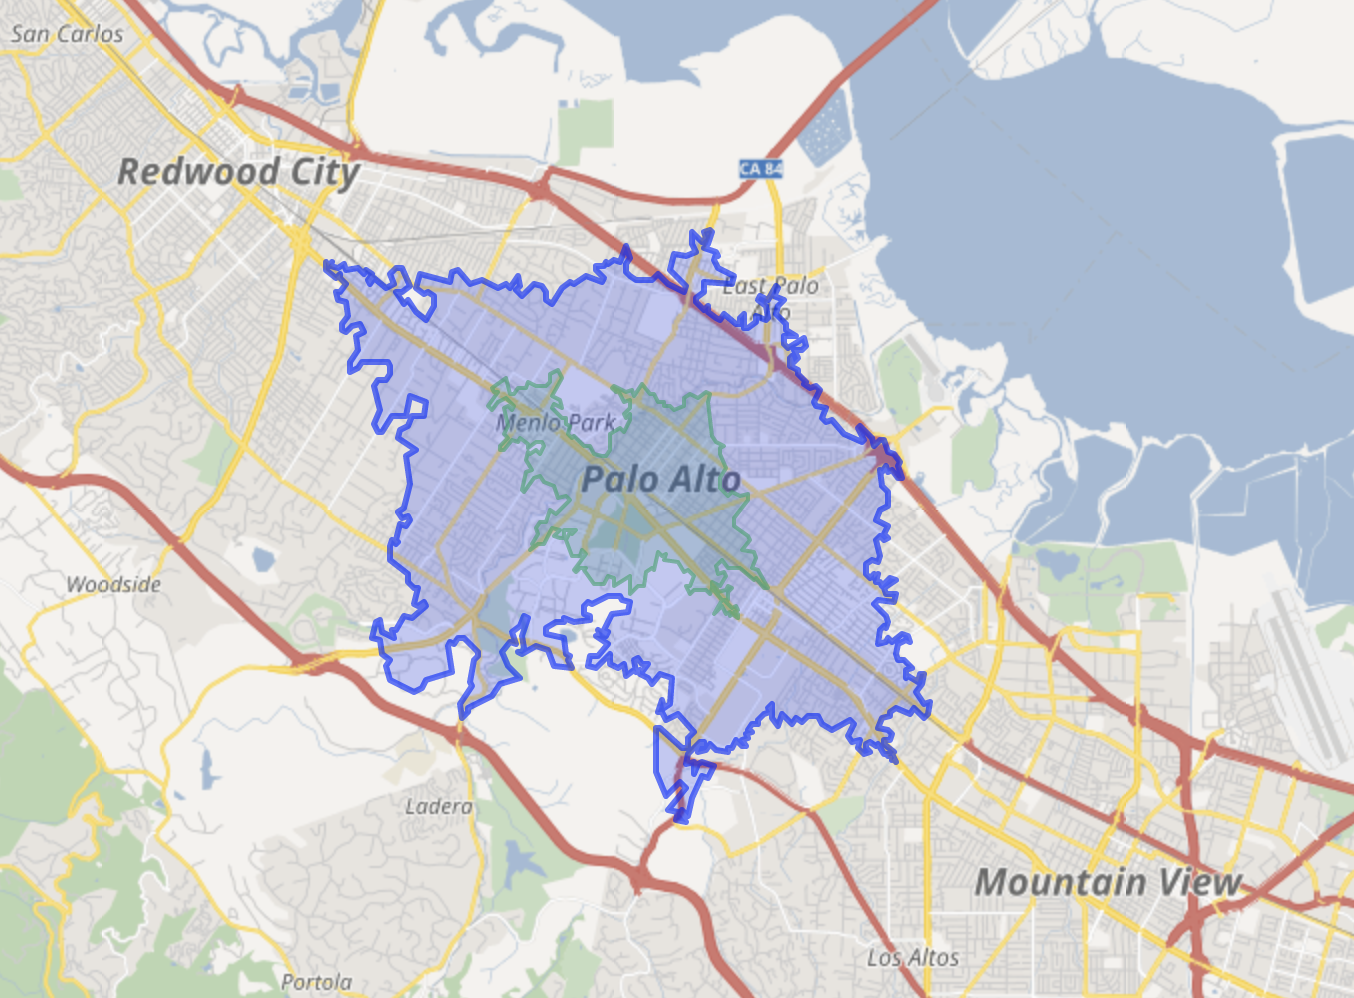

Tourism, real estate, retail site planning, transportation planning, and much else use isochrones–how many shoppers are within 20 minutes of my grocery store? How many points of interest are within walking distance of my hotel?


## Reactive isochrones in pydeck

Below we'll plot one isochrone from GraphHopper and then put together a demo application.

**Prerequisites**: You'll need a local instance of GraphHopper running on your machine for this demo.
See [the GraphHopper docs for setup](https://github.com/graphhopper/graphhopper/blob/master/README.md#docker). GraphHopper is an open source routing engine. I use the Dockerized version.

You also need to install `rtree` in your Python environment, which may have some additional dependencies.

Also, this demo will only work for Berlin, but you can configure GraphHopper to use other OpenStreetMap data. See [GeoFabrik](https://download.geofabrik.de/) to get an idea of your options.

In [ ]:
import json
from io import StringIO

import geopandas as gpd
import requests as r

## Client for GraphHopper API in a local Docker container
## See the GraphHopper readme to set up a local instance:
# https://github.com/graphhopper/graphhopper/blob/master/README.md#docker

BASE_URL = 'http://localhost:8989/isochrone'
TWENTY_MINUTES_IN_SECONDS = 1200

# Feel free to modify results by adding parameters from here: https://docs.graphhopper.com/#tag/Isochrone-API
def fetch_isochrone(lng: float = None, lat: float = None) -> list:
    params = {'point': f'{lat},{lng}', 'time_limit': TWENTY_MINUTES_IN_SECONDS}
    res = r.get(BASE_URL, params=params)
    if res.ok:
        return res.json().get('polygons')
    res.raise_for_status()

    
def convert_graphhopper_to_gdf(features: list) -> gpd.GeoDataFrame:
    feature_collection = json.dumps({"type": "FeatureCollection", "features": features})
    feature_collection_file = StringIO(feature_collection)
    feature_collection_file.name = 'test.geojson'
    gdf = gpd.read_file(feature_collection_file)
    return gdf


def fetch_isochrone_to_gdf(lng, lat):
    return convert_graphhopper_to_gdf(fetch_isochrone(lng, lat))

try:
    gdf = convert_graphhopper_to_gdf(fetch_isochrone(lng=13.3888599, lat=52.5170365))
except ConnectionRefusedError:
    print("Is GraphHopper running? See https://github.com/graphhopper/graphhopper/blob/master/README.md#docker")
else:
    display(gdf.head())

In [ ]:
import pydeck as pdk
import geopandas as gpd


isochrone_boundaries = pdk.Layer(
    "GeoJsonLayer",
    data=gdf,
    stroked=True,
    filled=True,
    line_width_min_pixels=2,
    pickable=True,
    get_fill_color=[0, 255, 255, 110],
    get_radius=1
)

# Berlin viewport
viewport = pdk.ViewState(**{
    "longitude": 13.3888599,
    "latitude": 52.5170365,
    "zoom": 9.0635693914205,
    "pitch": 0,
    "bearing": 0
})

d = pdk.Deck(isochrone_boundaries, initial_view_state=viewport, tooltip={'text': '20 minute isochrone'})

d.show()

## A richer application: Pubs within 20 minutes of a click

In [ ]:
import time

import pydeck as pdk
import pandas as pd
import geopandas as gpd
import ipywidgets

df = pd.read_csv('./filtered_biergartens.csv')
# We'll use this GeoDataFrame to join with the isochrone for a point-in-polygon calculation
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
filtered_df = None

scatter = pdk.Layer(
    'ScatterplotLayer',
    id='biergartens',
    data=df,
    stroked=True,
    pickable=True,
    filled=True,
    get_position=["lon", "lat"],
    get_fill_color=[255, 146, 0],
    get_line_color=[255, 255, 255],
    get_radius=200,
    get_line_width=50,
)

isochrone_boundaries = pdk.Layer(
    "GeoJsonLayer",
    id='isochrone',
    data=[],
    stroked=True,
    filled=True,
    line_width_min_pixels=2,
    pickable=True,
    get_fill_color=[0, 255, 255, 110],
    get_radius=1
)

# Berlin viewport
viewport = pdk.ViewState(**{
    "longitude": 13.3888599,
    "latitude": 52.5170365,
    "zoom": 9.0635693914205,
    "pitch": 0,
    "bearing": 0
})

deck = pdk.Deck([scatter, isochrone_boundaries], initial_view_state=viewport)

text = ipywidgets.HTML('Click near Berlin in the visualization to draw an isochrone')
point_counter = ipywidgets.HTML('')
h1 = ipywidgets.HTML('<h1>Neargarten: Biergartens within 20 minutes of any point in Berlin</h1>')

def update_isochrone(widget_instance, payload):
    global deck
    global gdf
    global text

    try:
        lng, lat = payload['data']['lngLat']
        text.value = 'Loading...'
        start = time.time()
        new_isochrone = fetch_isochrone_to_gdf(lng, lat)
        deck.layers[1].data = new_isochrone
        res = gpd.sjoin(new_isochrone, gdf, op='contains')
        end = time.time()
        text.value = '%s points within twenty minutes of clicked point (%s sec)' % (res.count()[0], round(end - start, 1))
        deck.update()
    except Exception as e:
        text.value = str(e)


def filter_by_bbox(row, west_lng, east_lng, north_lat, south_lat):
    return west_lng < row['lon'] < east_lng and south_lat < row['lat'] < north_lat


def filter_by_viewport(widget_instance, payload):
    global point_counter
    global df
    global filtered_df
    try:
        west_lng, north_lat = payload['data']['nw']
        east_lng, south_lat = payload['data']['se']
        filtered_df = df[df.apply(
            lambda row: filter_by_bbox(row, west_lng, east_lng, north_lat, south_lat), axis=1)]
        point_counter.value = 'Points in viewport: %s' % int(filtered_df.count()['lon'])
    except Exception as e:
        point_counter.value = 'Error: %s' % e

deck.deck_widget.on_click(update_isochrone)
deck.deck_widget.on_view_state_change(filter_by_viewport)


display(h1)
display(text)
display(point_counter)
deck.show()